# Sentiment Analysis of Financial News using USE and BERT Language Models

In [1]:
#import necessary python libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import tensorflow_hub as hub
import tensorflow_text as text
import time
from sklearn.model_selection import GridSearchCV

# 1. Loading and Splitting the dataset


### Link to the Financial News Dataset (fn)

https://huggingface.co/datasets/financial_phrasebank

https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news?select=all-data.csv


In [2]:
#load financial news dataset
df = pd.read_csv("all-data.csv", delimiter=',',encoding='latin-1', header=None, names=['sentiment', 'news'])

In [3]:
df.head()

,sentiment,news
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [4]:
#check the size of the dataset
df.shape

(4846, 2)

There are 4,846 news headlines/articles with their respective sentiment in the dataset.

### Split into train and test dataset

In [5]:
#import scikit-learn library for machine learning and also for sampling the dataset
from sklearn.model_selection import train_test_split

#the dataset is split into train and test dataset using random sampling
fntrain, fntest = train_test_split(df, test_size=0.2, random_state = 7)

print(f"{fntrain.shape[0]} train and {fntest.shape[0]} test instances")

3876 train and 970 test instances


The financial news dataset is split into train and test dataset.

In [6]:
#reset the index
fntrain = fntrain.reset_index(drop=True)

In [7]:
fntrain.head()

,sentiment,news
0,neutral,The investment would be some EUR5m .
1,positive,We hope to increase traffic volumes with the o...
2,positive,"For the current year , Raute expects its net s..."
3,positive,agreement with SHB 30 December 2009 - Finnish ...
4,positive,Diluted earnings per share ( EPS ) rose to EUR...


In [8]:
#reset the index for test dataset
fntest = fntest.reset_index(drop=True)

In [9]:
#info on train dataset
fntrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3876 entries, 0 to 3875
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  3876 non-null   object
 1   news       3876 non-null   object
dtypes: object(2)
memory usage: 60.7+ KB


In [10]:
#info on test dataset
fntest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970 entries, 0 to 969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  970 non-null    object
 1   news       970 non-null    object
dtypes: object(2)
memory usage: 15.3+ KB


In [11]:
#checking for null values in train and test dataset
fntrain.isnull().sum()

sentiment    0
news         0
dtype: int64

In [12]:
fntest.isnull().sum()

sentiment    0
news         0
dtype: int64

No null values in the dataset

# 2. Exploratory Data Analysis

In [13]:
#descriptive statistics on the dataset
fntrain.describe()

,sentiment,news
count,3876,3876
unique,3,3872
top,neutral,The issuer is solely responsible for the conte...
freq,2286,2


From the dataset, it can be seen that there is only 3,872 unique values which means there are 4 duplicates in the dataset

<AxesSubplot:xlabel='sentiment', ylabel='count'>

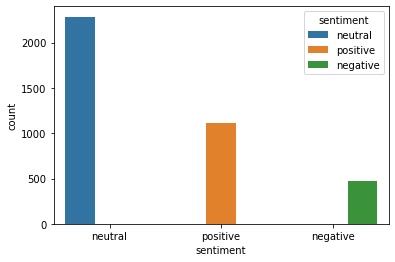

In [14]:
#plot the sentiment in train data
sns.countplot(x="sentiment", hue="sentiment", data = fntrain)

In [15]:
#count the classes in sentiment column
fntrain["sentiment"].value_counts()

neutral     2286
positive    1116
negative     474
Name: sentiment, dtype: int64

# 3. Data Cleaning, Transformation and Pre-processing

In [16]:
#drop duplicate values
fntrain = fntrain.drop_duplicates(subset="news")

In [17]:
#reset the index after dropping duplicates
fntrain=fntrain.reset_index(drop=True)

In [18]:
fntrain.shape

(3872, 2)

In [19]:
fntrain["sentiment"].value_counts()

neutral     2282
positive    1116
negative     474
Name: sentiment, dtype: int64

In [20]:
#seperating the target variable
target_fntrain = fntrain["sentiment"]
target_fntest = fntest["sentiment"]

In [21]:
target_fntrain.head()

0     neutral
1    positive
2    positive
3    positive
4    positive
Name: sentiment, dtype: object

# 4. Text Encoding - USE, BERT & Bag of Words

# 4.1. Create Bag-of-Words representations

"CountVectorizer" is a convenient facility to create bag-of-words representations of documents into a numpy array. Each row is considered as a document.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(
    strip_accents="unicode", 
    lowercase=True,
    tokenizer=None,        
    preprocessor=None,     
    stop_words="english",
    ngram_range=(1,1),     
    analyzer="word",       
    max_df=1.0,            
    min_df=1               
)

Now, "fit_transform" is called. This first fits on the data and then transforms the data. Creating numpy arrays where rows are documents, columns are features extracted from the documents, and values in the cells are counts of each feature in each document:

In [23]:
# fit and tranform using training dataset 
fntrain_counts = count_vectorizer.fit_transform(fntrain.news)

In [24]:
fntrain_counts.shape

(3872, 8779)

Thus, there 3872 rows, one for each news sentence, and 8779 columns, one for each feature.

Let's check the datatype of the data:

In [25]:
#check type
type(fntrain_counts)

scipy.sparse.csr.csr_matrix

It is stored in a sparse matrix due to the many zeros being present in each row and spare matrix also stores the data more efficiently. 

The fitted "count_vectorizer" stores the vocabulary of the text collection on which it was fitted.

In [26]:
#display the vocabulary
count_vectorizer.vocabulary_

{'investment': 4227,
 'eur5m': 3022,
 'hope': 3902,
 'increase': 4053,
 'traffic': 8080,
 'volumes': 8495,
 'opening': 5615,
 'freight': 3462,
 'scandinavia': 6983,
 'current': 2227,
 'year': 8715,
 'raute': 6429,
 'expects': 3138,
 'net': 5409,
 'sales': 6907,
 'operating': 5620,
 'result': 6710,
 'positive': 6103,
 'agreement': 824,
 'shb': 7171,
 '30': 286,
 'december': 2298,
 '2009': 198,
 'finnish': 3324,
 'financial': 3304,
 'services': 7129,
 'group': 3684,
 'aktia': 856,
 'hel': 3825,
 'aktav': 855,
 'concluded': 2002,
 'market': 4995,
 'making': 4925,
 'svenska': 7718,
 'handelsbanken': 3734,
 'sto': 7526,
 'parties': 5817,
 'said': 6894,
 'today': 8015,
 'diluted': 2445,
 'earnings': 2656,
 'share': 7159,
 'eps': 2848,
 'rose': 6810,
 'eur': 2907,
 '68': 505,
 '50': 408,
 'higher': 3850,
 'bit': 1357,
 'rates': 6419,
 'outgoing': 5706,
 'improves': 4027,
 'end': 2785,
 'user': 8320,
 'experience': 3143,
 'mobile': 5218,
 'broadband': 1493,
 'video': 8437,
 'conferencing': 201

The vocabulary is just a dictionary, where keys are original words and values are their indices in the produced matrix. The vocabulary will be used internally by the fitted vectorizer, when we transform the test data, deriving a document-by-feature matrix, which has the same columns in the same order as the training data.

Now, the same steps are repeated for the test dataset using "transform" method as the vectorizer has been fitted already.

In [27]:
#transform the test data
fntest_counts = count_vectorizer.transform(fntest.news)

In [28]:
fntest_counts.shape

(970, 8779)

It has 970 rows (one per news sentence), but the same number of columns as the training data, 8779.

### TF-IDF weighting for train and test dataset

Further, the observed counts are transformed into TF-IDF weights.

In [29]:
#import tf-idf transformer
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

First the transformer is fitted on the training data and then the fitted transformer is used to transform both the train and test dataset.

In [30]:
# fit and transform the training set with "fit_transform()"
fntrain_tfidf = tfidf_transformer.fit_transform(fntrain_counts)

In [31]:
# transform test
fntest_tfidf = tfidf_transformer.transform(fntest_counts)

### Standardize features for train and test dataset

A scaler is fitted on the training set and used to transform both the train and test datasets. The scaler used is a "MaxAbsScaler" as it is capable of dealing with sparse matrices.

In [32]:
from sklearn.preprocessing import MaxAbsScaler 

scaler = MaxAbsScaler()

bow_fntrain = scaler.fit_transform(fntrain_tfidf)
bow_fntest = scaler.transform(fntest_tfidf)

In [33]:
bow_fntrain

<3872x8779 sparse matrix of type '<class 'numpy.float64'>'
	with 46069 stored elements in Compressed Sparse Row format>

# 4.2. Text encoding using Universal Sentence Encoder (USE)

### Load the USE large - Version 5 Model

In [34]:
#link for universal sentence encoder - large/5
use_link = "https://tfhub.dev/google/universal-sentence-encoder-large/5"

#loading the model
use = hub.load(use_link)
print ("model %s loaded" % use_link)

model https://tfhub.dev/google/universal-sentence-encoder-large/5 loaded


In [35]:
#encoding the text in train dataset using USE
use_fntrain = use(fntrain.news).numpy()
use_fntest = use(fntest.news).numpy()

In [36]:
print(use_fntrain.shape, use_fntest.shape)

(3872, 512) (970, 512)


The datasets are now encoded into high dimensional vectors where each document or sentence is represneted as a 512 dimensional vector.

In [37]:
print(use_fntrain[:4])

[[ 3.6610790e-02 -6.1984926e-02 -4.7805827e-02 ... -3.9341887e-03
  -5.5702843e-02  3.2040048e-02]
 [ 4.1077740e-02 -9.7609669e-02 -3.3716664e-02 ... -6.4624776e-03
   2.9277474e-02  2.5035428e-02]
 [-5.3814696e-03 -6.3168831e-02  4.6145193e-02 ... -8.4165692e-02
  -7.3152319e-02 -6.9864310e-02]
 [ 3.8161073e-02 -9.9145643e-02  5.0585948e-02 ...  7.4696966e-02
  -1.3348102e-05  7.8196414e-02]]


# 4.3. Text encoding using BERT

### Load the BERT encoder model and it's respective preprocessor

### Text preprocessing for BERT and BERT (L-12, H-768, A-12)

In [38]:
prebert_link = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_link = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

#load the preprocessor
bert_preprocessor = hub.KerasLayer(prebert_link, name='preprocessing')

#load the bert encoder
bert_encoder = hub.KerasLayer(encoder_link, trainable=True, name='BERT_encoder')

## Train Dataset

In [39]:
#preprocess and encode the train dataset
fntrain_encoder_inputs = bert_preprocessor(fntrain.news)
fntrain_outputs = bert_encoder(fntrain_encoder_inputs)

bert_fntrain = fntrain_outputs["pooled_output"].numpy()

In [40]:
bert_fntrain.shape

(3872, 768)

In [41]:
bert_fntrain

array([[-0.89171666, -0.41728744, -0.93612653, ..., -0.8459161 ,
        -0.54556274,  0.87919694],
       [-0.7765689 , -0.4225265 , -0.9074052 , ..., -0.68077326,
        -0.6153284 ,  0.77851945],
       [-0.8450493 , -0.3459398 , -0.967964  , ..., -0.78770435,
        -0.57966256,  0.6618056 ],
       ...,
       [-0.8876149 , -0.49305916, -0.9793762 , ..., -0.9268743 ,
        -0.5198824 ,  0.8027915 ],
       [-0.92157984, -0.56204957, -0.9729948 , ..., -0.8546584 ,
        -0.6001062 ,  0.7973812 ],
       [-0.73801595, -0.45210016, -0.96859324, ..., -0.8097308 ,
        -0.57269645,  0.71344435]], dtype=float32)

## Test Dataset

In [42]:
#preprocess and encode the test dataset
fntest_encoder_inputs = bert_preprocessor(fntest.news)
fntest_outputs = bert_encoder(fntest_encoder_inputs)

bert_fntest = fntest_outputs["pooled_output"].numpy()

In [43]:
bert_fntest.shape

(970, 768)

# 5. Train - Linear SVM

# 5.1. Bag of Words

In [44]:
#import linear SVM model
from sklearn.svm import LinearSVC

lsvm = LinearSVC()

# specify the hyperparameters and their values
param_grid = {
    'C': [0.1, 0.5, 1, 2, 4, 6, 8, 10],
    'max_iter': [1000],
    'random_state': [7]
}

#5-fold cross-validation is used
grid_search = GridSearchCV(lsvm, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(bow_fntrain, target_fntrain)
end = time.time() - start
print(f"Took {end} seconds")

C:\Users\Public\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Took 6.480081081390381 seconds


In [45]:
#display the best parameters
grid_search.best_estimator_

LinearSVC(C=0.5, random_state=7)

In [46]:
#display the best cross-validation score
grid_search.best_score_

0.6692016333044111

In [47]:
#display the cross-validation in a descending order of performance
val_scores = grid_search.cv_results_["mean_test_score"]
train_scores = grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in grid_search.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(val_score, train_score, param)

0.6692016333044111 0.9931490472728166 {'C': 0.5, 'max_iter': 1000, 'random_state': 7}
0.6644169422699014 0.9955336315280763 {'C': 1, 'max_iter': 1000, 'random_state': 7}
0.6577772400005539 0.9975369787111859 {'C': 2, 'max_iter': 1000, 'random_state': 7}
0.650364830518254 0.9987475987764345 {'C': 4, 'max_iter': 1000, 'random_state': 7}
0.646054062687716 0.9987475987764345 {'C': 6, 'max_iter': 1000, 'random_state': 7}
0.6448313067485112 0.9684196300671115 {'C': 0.1, 'max_iter': 1000, 'random_state': 7}
0.6436359294133001 0.9989981549935084 {'C': 8, 'max_iter': 1000, 'random_state': 7}
0.6394991138459649 0.9991231482056925 {'C': 10, 'max_iter': 1000, 'random_state': 7}


Save the best model

In [48]:
import os
from joblib import dump

# create a folder where all trained models will be kept
if not os.path.exists("ML-models"):
    os.makedirs("ML-models")

#save the best model
dump(grid_search.best_estimator_, 'ML-models/bow-lsvm-fnclf.joblib')

['ML-models/bow-lsvm-fnclf.joblib']

# 5.2. Universal Sentence Encoder

In [49]:
#import linear SVM model
from sklearn.svm import LinearSVC

lsvm = LinearSVC()

# specify the hyperparameters and their values
param_grid = {
    'C': [0.1, 0.5, 1, 2, 4, 6, 8, 10],
    'max_iter': [1000],
    'random_state': [7]
}

#5-fold cross-validation is used
grid_search = GridSearchCV(lsvm, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(use_fntrain, target_fntrain)
end = time.time() - start
print(f"Took {end} seconds")

Took 60.64843797683716 seconds


In [50]:
#display the best parameters
grid_search.best_estimator_

LinearSVC(C=2, random_state=7)

In [51]:
#display the best cross-validation score
grid_search.best_score_

0.7160537604842404

In [52]:
val_scores = grid_search.cv_results_["mean_test_score"]
train_scores = grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in grid_search.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(val_score, train_score, param)

0.7160537604842404 0.8402469879922891 {'C': 2, 'max_iter': 1000, 'random_state': 7}
0.7147148068048341 0.8249794304265405 {'C': 1, 'max_iter': 1000, 'random_state': 7}
0.7118364944487945 0.869176715230427 {'C': 10, 'max_iter': 1000, 'random_state': 7}
0.7117024427555947 0.8067676860138263 {'C': 0.5, 'max_iter': 1000, 'random_state': 7}
0.7102727105534814 0.8662579041272075 {'C': 8, 'max_iter': 1000, 'random_state': 7}
0.7099618763198788 0.8552267781164067 {'C': 4, 'max_iter': 1000, 'random_state': 7}
0.709819346628646 0.8621802476068849 {'C': 6, 'max_iter': 1000, 'random_state': 7}
0.6906157074333434 0.7471947011793063 {'C': 0.1, 'max_iter': 1000, 'random_state': 7}


Save the best SVM Model

In [53]:
dump(grid_search.best_estimator_, 'ML-models/use-lsvm-fnclf.joblib')

['ML-models/use-lsvm-fnclf.joblib']

# 5.3. BERT

In [54]:
#import linear SVM model
from sklearn.svm import LinearSVC

lsvm = LinearSVC()

# specify the hyperparameters and their values
param_grid = {
    'C': [0.1, 0.5, 1, 2, 4, 6, 8, 10],
    'max_iter': [1000],
    'random_state': [7]
}

#5-fold cross-validation is used
grid_search = GridSearchCV(lsvm, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(bert_fntrain, target_fntrain)
end = time.time() - start
print(f"Took {end} seconds")

C:\Users\Public\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Public\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Public\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Public\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Public\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of itera

Took 626.7612457275391 seconds


C:\Users\Public\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [55]:
#display the best parameters
grid_search.best_estimator_

LinearSVC(C=0.5, random_state=7)

In [56]:
#display the best cross-validation score
grid_search.best_score_

0.7061202540460015

In [57]:
val_scores = grid_search.cv_results_["mean_test_score"]
train_scores = grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in grid_search.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(val_score, train_score, param)

0.7061202540460015 0.8229967403063547 {'C': 0.5, 'max_iter': 1000, 'random_state': 7}
0.6933509041671161 0.8192149498188586 {'C': 2, 'max_iter': 1000, 'random_state': 7}
0.6928330787343648 0.7656731777566906 {'C': 0.1, 'max_iter': 1000, 'random_state': 7}
0.6924528689880661 0.838100454478589 {'C': 4, 'max_iter': 1000, 'random_state': 7}
0.6912789150635454 0.8312701763761938 {'C': 1, 'max_iter': 1000, 'random_state': 7}
0.6842059874750579 0.813990890632053 {'C': 8, 'max_iter': 1000, 'random_state': 7}
0.6706023580145368 0.8163527151818941 {'C': 6, 'max_iter': 1000, 'random_state': 7}
0.6330288001816967 0.7628387693052474 {'C': 10, 'max_iter': 1000, 'random_state': 7}


Save the best SVM Model

In [58]:
dump(grid_search.best_estimator_, 'ML-models/bert-lsvm-fnclf.joblib')

['ML-models/bert-lsvm-fnclf.joblib']

# 6. Sentiment Analysis using the Best Models - SVM

Loading all three models:

In [59]:
from joblib import load

#loading the best lsvm models for bow, use and bert
bow_lsvm = load("ML-models/bow-lsvm-fnclf.joblib")
use_lsvm = load("ML-models/use-lsvm-fnclf.joblib")
bert_lsvm = load("ML-models/bert-lsvm-fnclf.joblib")

## 6.1. BOW

In [60]:
from sklearn.metrics import precision_recall_fscore_support
# bow-lsvm
bow_yhat = bow_lsvm.predict(bow_fntest)

# macro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(target_fntest, bow_yhat, average="macro")
print("Bag of Words Linear SVM Model:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

Bag of Words Linear SVM Model:
Precision: 0.6751923758502706
Recall: 0.6367711014467027
F score: 0.6522739824195661


Plot the confusion matrix

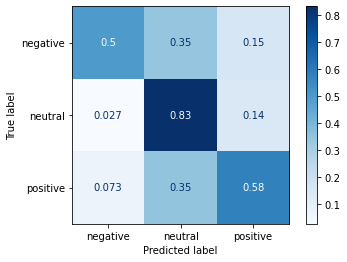

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(bow_lsvm, bow_fntest, target_fntest,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

## 6.2. Universal Sentence Encoder

In [62]:
# use_lsvm
use_yhat = use_lsvm.predict(use_fntest)

# macro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(target_fntest, use_yhat, average="macro")
print("Universal Sentence Encoder Linear SVM Model:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

Universal Sentence Encoder Linear SVM Model:
Precision: 0.6996658302917425
Recall: 0.6744652525073223
F score: 0.6855509899893245


Plot the confusion matrix

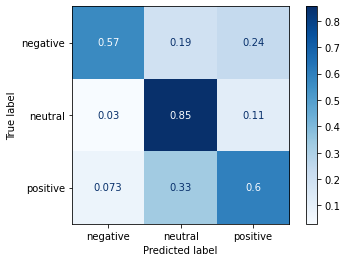

In [63]:
plot_confusion_matrix(use_lsvm, use_fntest, target_fntest,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

## 6.3. BERT

In [64]:
# bert-lsvm
bert_yhat = bert_lsvm.predict(bert_fntest)

# macro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(target_fntest, bert_yhat, average="macro")
print("BERT Linear SVM Model:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

BERT Linear SVM Model:
Precision: 0.7423681493010017
Recall: 0.7055021130462684
F score: 0.7217719029683701


Plot the confusion matrix

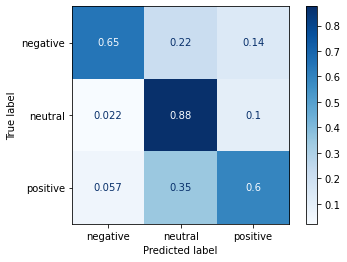

In [65]:
plot_confusion_matrix(bert_lsvm, bert_fntest, target_fntest,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

# 7. Sentiment Analysis using BERT & Neural Networks

## Train

In [75]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

# specify the hyperparameters and their values
param_grid = {
    'hidden_layer_sizes': [(100,), (200,), (100, 50,), (100, 100,), (100, 50, 25,)],
    'solver': ['adam'],
    'learning_rate': ['constant'],
    'max_iter': [150, 200, 250],
    'random_state': [7]
}

#5-fold cross-validation is used
grid_search = GridSearchCV(mlp, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(bert_fntrain, target_fntrain)
end = time.time() - start
print(f"Took {end} seconds")

C:\Users\Public\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Public\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Public\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Public\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Public\anaconda3\lib\site-packages\sklearn\neural_network\_

Took 1749.0622384548187 seconds


In [76]:
grid_search.best_score_

0.6848252278403341

In [77]:
grid_search.best_estimator_

MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=250, random_state=7)

In [78]:
val_scores = grid_search.cv_results_["mean_test_score"]
train_scores = grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in grid_search.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(val_score, train_score, param)

0.6848252278403341 0.7988553657095395 {'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'max_iter': 250, 'random_state': 7, 'solver': 'adam'}
0.6803914598455747 0.7749993276622062 {'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'max_iter': 150, 'random_state': 7, 'solver': 'adam'}
0.6796503178111553 0.787700769394763 {'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'max_iter': 200, 'random_state': 7, 'solver': 'adam'}
0.6763657762388043 0.7654242509442312 {'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 200, 'random_state': 7, 'solver': 'adam'}
0.6756351765532955 0.7653257669522714 {'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 250, 'random_state': 7, 'solver': 'adam'}
0.6745368969993549 0.7604147447029124 {'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 150, 'random_state': 7, 'solver': 'adam'}
0.6696958783705391 0.7586780105627373 {'hidden_layer_sizes': (100,), 'l

In [79]:
dump(grid_search.best_estimator_, 'ML-models/bert-mlp-fnclf.joblib')

['ML-models/bert-mlp-fnclf.joblib']

## Test

In [80]:
#loading the best bert-mlp model
bert_mlp = load("ML-models/bert-mlp-fnclf.joblib")

In [81]:
from sklearn.metrics import precision_recall_fscore_support
# bert-mlp
bertmlp_yhat = bert_mlp.predict(bert_fntest)

# macro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(target_fntest, bertmlp_yhat, average="macro")
print("BERT MLP Model:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

BERT MLP Model:
Precision: 0.7025523276903695
Recall: 0.6939956259828453
F score: 0.692328067433881


Plot the confusion matrix

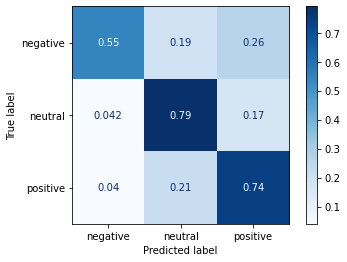

In [82]:
plot_confusion_matrix(bert_mlp, bert_fntest, target_fntest,
                                 cmap=plt.cm.Blues,
                                 normalize='true')